# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### First, download the data from: https://www.kaggle.com/ntnu-testimon/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [6]:
paysim1 = pd.read_csv("C:/Users/victo/Downloads/archive/PS_20174392719_1491204439457_log.csv")

In [7]:
paysim1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


**Type and amount seem to be the most important features at first sight**

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [12]:
paysim1.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [14]:
correlation = paysim1.corr()

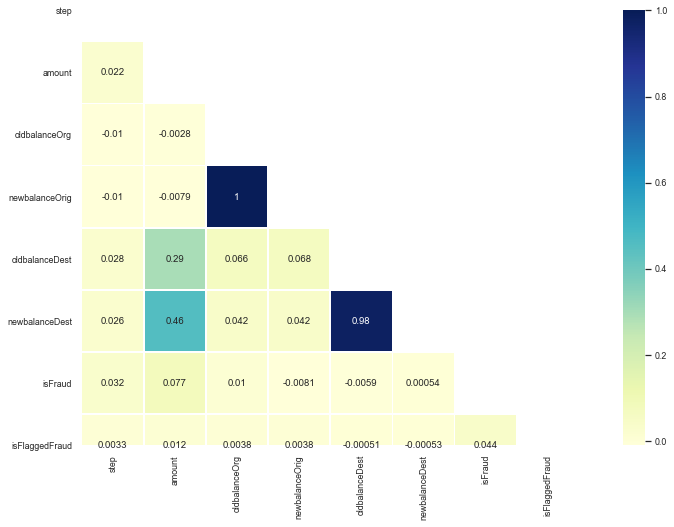

In [16]:
plt.figure(figsize=(16,8))
sns.set(font_scale=0.8)
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(correlation, mask=mask, vmax=1, square=True, cmap="YlGnBu", linewidths=.5, annot=True)

**Amount and step will be the most important features from my point of view**

### What is the distribution of the outcome? 

In [17]:
paysim1.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [19]:
paysim1['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [20]:
paysim1[paysim1['isFraud'] == 1]['type'].value_counts()

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

In [21]:
paysim1_reduced = paysim1[paysim1['type'].str.contains('CASH_OUT|TRANSFER')].copy()

In [22]:
paysim1_reduced['isFraud'].value_counts()

0    2762196
1       8213
Name: isFraud, dtype: int64

In [23]:
paysim1_reduced.drop(['nameOrig', 'nameDest'], axis=1, inplace = True)

In [26]:
paysim1_reduced = pd.get_dummies(paysim1_reduced, columns=['type'])

In [27]:
paysim1_reduced.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_TRANSFER
2,1,181.00,181.0,0.0,0.0,0.00,1,0,0,1
3,1,181.00,181.0,0.0,21182.0,0.00,1,0,1,0
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,0,1,0
19,1,215310.30,705.0,0.0,22425.0,0.00,0,0,0,1
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,0,1


In [32]:
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE

random_sample = RandomUnderSampler(random_state = 42)

X_rus, y_rus = random_sample.fit_resample(paysim1_reduced.drop('isFraud', axis=1), paysim1_reduced['isFraud'])

print(X_rus.shape)
print(y_rus.shape)

(16426, 9)
(16426,)


In [36]:
nearmiss = NearMiss()

X_nearmiss, y_nearmiss = nearmiss.fit_resample(paysim1_reduced.drop('isFraud', axis=1), paysim1_reduced['isFraud'])

print(X_nearmiss.shape)
print(y_nearmiss.shape)

(16426, 9)
(16426,)


### Run a logisitc regression classifier and evaluate its accuracy.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(paysim1_reduced.drop('isFraud', axis=1), paysim1_reduced['isFraud'], random_state = 42, test_size=0.2)
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_rus, y_rus, random_state=42, test_size=0.2)
X_train_nr, X_test_nr, y_train_nr, y_test_nr = train_test_split(X_nearmiss, y_nearmiss,random_state=42, test_size=0.2)

In [38]:
LR = LogisticRegression()

In [39]:
y_pred = LR.fit(X_train, y_train).predict(X_test)

In [40]:
y_pred_rus = LR.fit(X_train_rus, y_train_rus).predict(X_test_rus)

In [42]:
y_pred_nearmiss = LR.fit(X_train_nr, y_train_nr).predict(X_test_nr)

In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [47]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test_rus,y_pred_rus))
print(classification_report(y_test_rus, y_pred_rus))
print(confusion_matrix(y_test_nr,y_pred_nearmiss))
print(classification_report(y_test_nr, y_pred_nearmiss))

[[551690    746]
 [   919    727]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552436
           1       0.49      0.44      0.47      1646

    accuracy                           1.00    554082
   macro avg       0.75      0.72      0.73    554082
weighted avg       1.00      1.00      1.00    554082

[[1459  190]
 [  57 1580]]
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      1649
           1       0.89      0.97      0.93      1637

    accuracy                           0.92      3286
   macro avg       0.93      0.92      0.92      3286
weighted avg       0.93      0.92      0.92      3286

[[1473  176]
 [ 217 1420]]
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1649
           1       0.89      0.87      0.88      1637

    accuracy                           0.88      3286
   macro avg       0.88      0.88      

**The model with the randomundersampler works best**

### Now pick a model of your choice and evaluate its accuracy.

In [49]:
from sklearn.neighbors import KNeighborsClassifier

In [50]:
#KNN

knn_rus =  KNeighborsClassifier(n_neighbors = 3).fit(X_train_rus, y_train_rus)

y_knn_pred_rus = knn_rus.predict(X_test_rus)

print(confusion_matrix(y_test_rus, y_knn_pred_rus))

print(classification_report(y_test_rus, y_knn_pred_rus))

[[1561   88]
 [  75 1562]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1649
           1       0.95      0.95      0.95      1637

    accuracy                           0.95      3286
   macro avg       0.95      0.95      0.95      3286
weighted avg       0.95      0.95      0.95      3286



In [51]:
knn_nr = KNeighborsClassifier(n_neighbors = 3).fit(X_train_nr, y_train_nr)

y_knn_pred_nr = knn_nr.predict(X_test_nr)

print(confusion_matrix(y_test_nr, y_knn_pred_nr))

print(classification_report(y_test_nr, y_knn_pred_nr))

[[1562   87]
 [  65 1572]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1649
           1       0.95      0.96      0.95      1637

    accuracy                           0.95      3286
   macro avg       0.95      0.95      0.95      3286
weighted avg       0.95      0.95      0.95      3286



In [52]:
from sklearn.neural_network import MLPClassifier

In [54]:
#Neuronal network

mlp = MLPClassifier(hidden_layer_sizes=(400, ),random_state =42).fit(X_train_rus, y_train_rus)
y_mlp_pred_rus = mlp.predict(X_test_rus)

print(confusion_matrix(y_test_rus, y_mlp_pred_rus))

print(classification_report(y_test_rus, y_mlp_pred_rus))

[[1621   28]
 [ 133 1504]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1649
           1       0.98      0.92      0.95      1637

    accuracy                           0.95      3286
   macro avg       0.95      0.95      0.95      3286
weighted avg       0.95      0.95      0.95      3286



### Which model worked better and how do you know?

**KNN with under sampling with NearMiss gives the best results**